In [1]:
import pandas as pd
import numpy as np

# I. US Kidney Recipient Candidates

## Characterizing the distribution

In [3]:
included_rows = [
    0, # WL_ORG - Organ type
    54, # INIT_AGE - Initial age of recipient at listing
    61, # INIT_DATE - Initial date of recipient listing
    24, # GENDER - Recipient gender
    63, # ETHCAT - Recipient ethnicity
    385, # HGT_CM_CALC - Recipient height (cm)
    386, # WGT_KG_CALC - Recipient weight (kg)
    33, # EDUCATION - Recipient highest education at listing
    32, # PERM_STATE - Recipient state of residency
    31, # CITIZEN_COUNTRY - Recipient country of residency
    103, # PRI_PAYMENT_TCR_KI - Recipient primary projected payment source at listing
    6, # CREAT_CLEAR - Recipient CrCl at listing
    7, # GFR - Recipient GFR at listing
    25, # ABO - Recipient ABO blood type
    37, # DIAB - Recipient diabetes at listing
    8, # DONATION - Receives allocation points for previously donating an organ
    2, # NUM_PREV_TX - Recipient number of previous transplants
    47, # INIT_CPRA - Recipient CPRA at listing
    48, # END_CPRA - Recipient most recent CPRA
    58, # DIALYSIS_DATE - Date recipient started regular dialysis for ESRD
    118, # TX_DATE - Transplant date
    68, # COMPOSITE_DEATH_DATE - Death date
    67, # DAYSWAIT_ALLOC - official waiting time for allocation priority as measured by the OPTN standards
]
kidpan_data = pd.read_csv(
    "C:/Users/brand/Desktop/STAR_Delimited/Delimited Text File 202312/Kidney_ Pancreas_ Kidney-Pancreas/KIDPAN_DATA.DAT",
    sep="\t",
    usecols=included_rows
)
colnames = pd.read_csv(
    "C:/Users/brand/Desktop/STAR_Delimited/Analysis/KIDPAN_DATA_colnames.csv",
    sep=",",
    header=0,
    skiprows=lambda x : x-1 not in included_rows + [-1]
)
kidpan_data.columns = list(colnames["LABEL"])
kidpan_data = kidpan_data[kidpan_data["WL_ORG"] == "KI"]

In [2]:
kidpan_data["GENDER"].unique()

NameError: name 'kidpan_data' is not defined

In [13]:
kidpan_data = kidpan_data.replace(".", np.nan)

for numeric_column in ["INIT_AGE", "HGT_CM_CALC", "WGT_KG_CALC", "CREAT_CLEAR", "GFR", "NUM_PREV_TX", "INIT_CPRA", "END_CPRA", "DAYSWAIT_ALLOC"]:
    kidpan_data[numeric_column] = kidpan_data[numeric_column].astype(float)
for date_column in ["INIT_DATE", "DIALYSIS_DATE", "TX_DATE", "COMPOSITE_DEATH_DATE"]:
    kidpan_data[date_column] = pd.to_datetime(kidpan_data[date_column].replace(".", np.nan))

kidpan_data = kidpan_data.replace({"ETHCAT" : {
    1 : "White, Non-Hispanic",
    2 : "Black, Non-Hispanic",
    4 : "Hispanic/Latino",
    5 : "Asian, Non-Hispanic",
    6 : "Amer Ind/Alaska Native, Non-Hispanic",
    7 : "Native Hawaiian/other Pacific Islander, Non-Hispanic",
    9 : "Multiracial, Non-Hispanic",
    998 : np.nan,
}})

<Axes: >

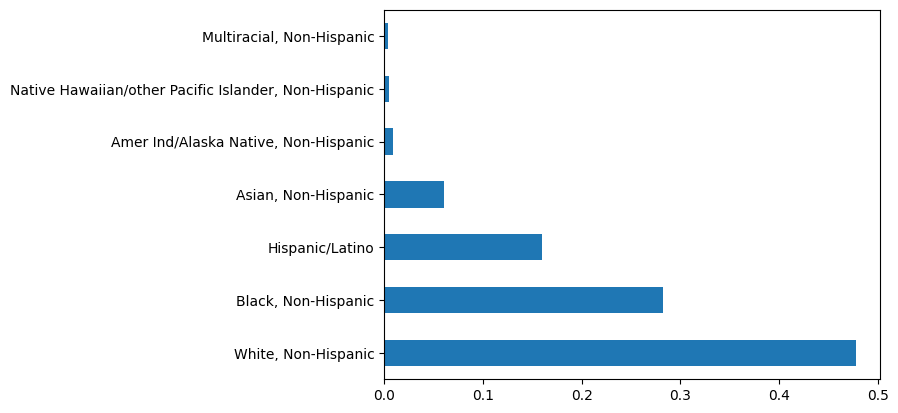

In [25]:
(kidpan_data["ETHCAT"].value_counts()/kidpan_data.shape[0]).plot.barh()